# LSTM 模型

In [1]:
# change to the directory of the working file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# import the necessary modules
from utils.utils import *
from datasets.data_loader import *
from models.lstm import LSTM_Variant
from utils.plot_figures import *

In [3]:
# load the data
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

charset = '?P25$]FO-S.Hc=71(ln63NC4[+)^@'
charlen = len(charset)
print('the charset(inculde begin end and pad char) achieved from dataset :', charset)
print('the total num of charset is :', charlen)
# create the char to index and index to char dictionary
char_to_index = dict((c, i) for i, c in enumerate(charset))
index_to_char = dict((i, c) for i, c in enumerate(charset))
char_list = [k for k, v in char_to_index.items()]

cudnn.benchmark = True
lr = 2e-3
batch_size = 512
n_epoch = 2
seqlen = 127

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load the training and testing data
src_smiles, tgt_smiles = smiles_padding(train_smiles)
tgt_seq = smiles_to_sequence(tgt_smiles, char_to_index)
tgt_seq = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq]).long()
src_smiles_test, tgt_smiles_test = smiles_padding(test_smiles)
tgt_seq_test = smiles_to_sequence(tgt_smiles_test, char_to_index)
tgt_seq_test = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq_test]).long()
# create the dataset and dataloader
train_dataset = SeqDataset(train_zeo, train_syn, tgt_seq)
test_dataset = SeqDataset(test_zeo, test_syn, tgt_seq_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the model
model = LSTM_Variant(charlen, embedding_dim=128, hidden_dim=256, conditional_synthesis_dim=24, num_layers=2, dropout=0.5)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device.type == 'cuda':
    model = model.to(device)
    criterion = criterion.to(device)

total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))  # print the total parameters

the charset(inculde begin end and pad char) achieved from dataset : ?P25$]FO-S.Hc=71(ln63NC4[+)^@
the total num of charset is : 29
cuda
total parameters: 0.96M


In [4]:
# define the training and testing functions
def sample_from_logits(logits, temperature=1.0):
    logits = logits / temperature  # (batch_size, vocab_size)
    probs = F.softmax(logits, dim=-1)  # (batch_size, vocab_size)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)  # (batch_size,)

def train(epoches, model, iterator, optimizer, criterion, device):
    # teaching forcing
    epoch_loss = 0
    train_loss_list = []
    test_loss_list = []
    for epoch in range(epoches):
        model.train()
        for i, (zeo, syn, label) in enumerate(iterator):
            # concat the zeo and syn
            conditional_synthesis = torch.cat([zeo, syn], dim=1)
            conditional_synthesis, label = conditional_synthesis.to(device), label.to(device)
            optimizer.zero_grad()
            batch_size, seq_len = label.shape
            
            # 这里有问题，应该是输入去掉最后一个token，输出去掉第一个token
            # forward pass
            output, _ = model(conditional_synthesis, label[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            label = label[:, 1:].contiguous().view(-1)
            # # forward pass
            # output, _ = model(conditional_synthesis, label)
            # output_dim = output.shape[-1] # vocab size
            # # ignore the last token and reshape the output
            # output = output[:, :-1, :].contiguous().view(-1, output_dim) # (batch_size * seq_len, vocab_size)
            # # ignore the first token and reshape the label
            # label = label[:, 1:].contiguous().view(-1) # (batch_size * seq_len)
            
            # calculate the loss
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            # print information
            if i % 100 == 0:
                print(f'Batch: {i}, Loss: {loss.item()}')
        
        # calculate the average loss
        train_loss_list.append(epoch_loss / len(iterator))
        test_loss = test(model, test_dataloader, criterion, device)
        test_loss_list.append(test_loss)
        epoch_loss = 0
        
        print(f'Epoch: {epoch}, Train Loss: {epoch_loss / len(iterator)}, Test Loss: {test_loss}')
    return train_loss_list, test_loss_list

def test(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    generated_sequences = []
    with torch.no_grad():
        for i, (zeo, syn, label) in enumerate(iterator):
            # concat the zeo and syn
            conditional_synthesis = torch.cat([zeo, syn], dim=1)
            conditional_synthesis, label = conditional_synthesis.to(device), label.to(device)
            batch_size = conditional_synthesis.shape[0]
            # set the initial hidden state
            hidden = None
            # set the initial input (batch_size, 1)
            generated_sequence = label[:, :1] # (batch_size, 1)
            batch_loss = 0
            
            # auto-regressive
            for t in range(label.shape[1]):
                # forward pass
                current_token = generated_sequence[:, -1].unsqueeze(1) # (batch_size, 1)
                output, hidden = model(conditional_synthesis, current_token, hidden) # (batch_size, 1, vocab_size)
                
                # sample for the next input
                next_token = sample_from_logits(output.squeeze(1)) # (batch_size,)
                generated_sequence = torch.cat([generated_sequence, next_token.unsqueeze(1)], dim=1) # (batch_size, t+2)
                
                # calculate the loss
                output_dim = output.shape[-1]
                output = output.view(-1, output_dim) # (batch_size, vocab_size)
                label_t = label[:, t]
                loss = criterion(output, label_t)
                batch_loss += loss.item()
            
            batch_loss /= label.shape[1]
            total_loss += batch_loss
            generated_sequences.append(generated_sequence)
        
        # calculate the average loss
        total_loss /= len(iterator)
        
    # convert the generated sequences to smiles
    generated_sequences = torch.cat(generated_sequences, dim=0).cpu().numpy()
    generated_sequences = sequence_to_smiles(generated_sequences, index_to_char)
    print(generated_sequences[:10])
    return total_loss

In [5]:
# train the model
train_loss_list, test_loss_list = train(n_epoch, model, train_dataloader, optimizer, criterion, device)

Batch: 0, Loss: 3.3549416065216064
Batch: 100, Loss: 0.27437087893486023
Batch: 200, Loss: 0.20944635570049286
seq_list: [[27 22 18 ...  0  0  0]
 [27 22 15 ...  0  0  0]
 [27 22 24 ...  0  0  0]
 ...
 [27 22 15 ...  0  0  0]
 [27 22 22 ...  0  0  0]
 [27 22 16 ...  0  0  0]]
<class 'numpy.ndarray'>
['^Cn1cc[n+](Cc2c(C)cc2)ccc1', '^C1C2C3C[N+](C)(CC4CC(C4)CCCC3)OC1', '^C[N+]1(C)CCCCC1', '^C[N+](C2)(CCN(CC)CCCCC2)C', '^c1ccccc1(C[N+](C)(C)C)CCC2', '^[n+]1(C)c(cccn1)c1ccccc1', '^C1[N+]2(C)CC(C)C=(CCC2C=C1)CC(C)CCC2', '^c1[n+](CC[n+]2ccn(c2C)C)cc(-2', '^C1CCC2CC[N+]21C1CC(C[N+]3(CCCC2)C)(C)CC1', '^C[n+]1(CCCCC)cccc1']
Epoch: 0, Train Loss: 0.0, Test Loss: 1.9663331562097544
Batch: 0, Loss: 0.1896256059408188
Batch: 100, Loss: 0.16198010742664337
Batch: 200, Loss: 0.15121105313301086
seq_list: [[27 22 16 ...  0  0  0]
 [27 22 15 ...  0  0  0]
 [27 24 18 ...  0  0  0]
 ...
 [27 24 21 ...  0  0  0]
 [27 24 21 ...  0  0  0]
 [27 22 15 ...  0  0  0]]
<class 'numpy.ndarray'>
['^C(C[N+]1(C2CC3CC

In [6]:
# save the model
torch.save(model.state_dict(), 'checkpoints/LSTM_Variant.pth')

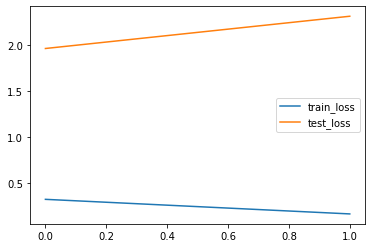

In [7]:
# plot the training and testing loss
plot_loss(train_loss_list, test_loss_list, 'LSTM_Variant')